In [25]:
import torch
import copy
import random
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.interpolate import interp1d
import torch.nn.utils.rnn as rnn_utils

In [26]:
#define the function and classes used in this project 
def linear_interpolation(a):
    "implementing linear interpolation over a sequence."
    y=[val for idx,val in enumerate(a) if val>0]
    x=[idx for idx,val in enumerate(a) if val>0]
    linear_interpolation = interp1d(x, y,kind="linear",fill_value='extrapolate')
    y_interpolated_linear = linear_interpolation(np.linspace(0, len(a)-1, num=len(a), endpoint=True))
    return y_interpolated_linear

def next_interpolation(a):
    "implementing interpolation with nearest value over a sequence."
    y=[val for idx,val in enumerate(a) if val>0]
    x=[idx for idx,val in enumerate(a) if val>0]
    linear_interpolation = interp1d(x, y,kind="next",fill_value='extrapolate')
    y_interpolated_linear = linear_interpolation(np.linspace(0, len(a)-1, num=len(a), endpoint=True))
    return y_interpolated_linear

def extend_tensor(x):
    "extend a tensor sequence with zero value to a defined length."
    new_x=copy.deepcopy(x)
    if len(x[0])<max_length:
        temp_tensor=torch.zeros(max_length)
        temp_tensor[:len(x[0])] = x[0]
        new_x[0]=temp_tensor
    return new_x

def reverse_tensor(tensor):
    "reverse a tensor sequence."
    inv_idx = torch.arange(tensor.size(0)-1, -1, -1).long()
    inv_tensor = tensor.index_select(0, inv_idx)
    inv_tensor = tensor[inv_idx]
    return inv_tensor

class LSTM_post_padding(nn.Module):
    "this class define LSTM model with post-padding input."
    def __init__(self):
        super(LSTM_post_padding, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)  

    def forward(self, seq):
        
        r_out, (h_n, h_c) = self.lstm(seq)
        batch_lengths = [len(x) for x in seq]
        #extract the last output at the end of sequence before padding
        idx=(torch.LongTensor(batch_lengths) - 1).view(-1,1).expand(len(batch_lengths), r_out.size(2)).unsqueeze(1)
        output = r_out.gather(1, Variable(idx)).squeeze(1)
        last_output=self.linear(output)
        
        return last_output

class LSTM_pre_padding(nn.Module):
    "this class define LSTM model with pre-padding input."
    def __init__(self):
        super(LSTM_pre_padding, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)  

    def forward(self, seq):
        r_out, (h_n, h_c) = self.lstm(seq)
        last_output=self.linear(r_out[:,-1,:])
            
        return last_output
    
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        """
        define a cnn with two conv layers (experiment with the number of channels and kernal sizes) 
        , then one fully connected layers.
        """
        self.conv1=nn.Conv1d(1,10,5)
        self.pool1=nn.MaxPool1d(2,2)
        self.conv2=nn.Conv1d(10,20,6)
        self.pool2=nn.MaxPool1d(2,2)
        self.linear=nn.Linear(860,2)
        
    def forward(self, x):
        """define the forward pass of the cnn with a relu activation function for each hidden layer.
        """
        x=self.conv1(x)
        x=self.pool1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=self.pool2(x)
        x = x.view(-1, 860)
        x=F.relu(x)
        x=self.linear(x)
        return x

In [27]:
left_excel = pd.ExcelFile('PDleft.xlsx')
right_excel = pd.ExcelFile('PDright.xlsx')

left_sheet_names=left_excel.sheet_names
left_sheet_num=len(left_excel.sheet_names)
right_sheet_names=right_excel.sheet_names
right_sheet_num=len(right_excel.sheet_names)

In [28]:
#create dictionary for left and right dataset, key is sheet_name+individual_name such as T1P5Chinese, value is sequence
dict_left={}
dict_left_key_list=[]
for i in range(left_sheet_num):
    sheet = left_excel.parse(i)
    column_num=len(sheet.columns)
    for j in range(column_num):
        key=left_sheet_names[i].strip()+sheet.columns[j].strip()
        dict_left[key]=list(sheet[sheet.columns[j]])
        dict_left_key_list.append(key)

        
dict_right={}
dict_right_key_list=[]
for i in range(right_sheet_num):
    sheet = right_excel.parse(i)
    column_num=len(sheet.columns)
    for j in range(column_num):
        key=right_sheet_names[i].strip()+sheet.columns[j].strip()
        dict_right[key]=list(sheet[sheet.columns[j]])
        dict_right_key_list.append(key)
print("right dataset has ",len(dict_right)," data(sequences)") 
print("left dataset has ",len(dict_left)," data(sequences)")  

right dataset has  400  data(sequences)
left dataset has  400  data(sequences)


In [29]:
#check nan column in both left and right dataset, result shows there are ten same 10 individuals with missing value in both dataset
left_nan_key=[]
right_nan_key=[]
for key in dict_right_key_list:
    if sum(np.isnan(dict_left[key]))==len(dict_left[key]):
        left_nan_key.append(key)
    if sum(np.isnan(dict_right[key]))==len(dict_right[key]):
        right_nan_key.append(key)
print("left dataset has 10 NaN column\n",left_nan_key)
print("--------------------------------")
print("right dataset has 10 NaN column\n",right_nan_key)

left dataset has 10 NaN column
 ['T1P5Chinese', 'T2P7Chinese', 'T2P8Chinese', 'T7P12Caucasian', 'F1P26Caucasian', 'F2P6Chinese', 'F2P22Caucasian', 'F4P12Caucasian', 'F5P13Caucasian', 'F6P26Caucasian']
--------------------------------
right dataset has 10 NaN column
 ['T1P5Chinese', 'T2P7Chinese', 'T2P8Chinese', 'T7P12Caucasian', 'F1P26Caucasian', 'F2P6Chinese', 'F2P22Caucasian', 'F4P12Caucasian', 'F5P13Caucasian', 'F6P26Caucasian']


In [30]:
#drop missing column
for key in left_nan_key:
    del dict_left[key]
    del dict_right[key]
for key in left_nan_key:
    dict_right_key_list.remove(key)
    dict_left_key_list.remove(key)
print("After droping missing column, there are ",len(dict_right)," columns in both dataset")

After droping missing column, there are  390  columns in both dataset


F8P22Caucasian
Left dataset has  176  columns including zero value
In Left dataset, the biggest zero value proportion is  0.573 the number is 52 , this individual is F8P22Caucasian
Right dataset has  176  columns including zero value
In Right dataset, the biggest zero value proportion is  0.2773 the number is 33


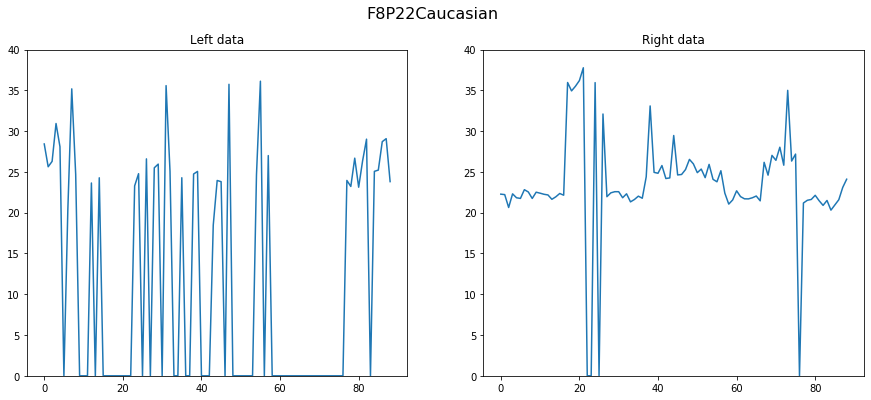

In [31]:
#calculate how many zero value in each sequence
#F8P22Caucasian has large number of zero
zero_value_left=[]
zero_value_left_prop=[]
zero_value_right=[]
zero_value_right_prop=[]

for key in dict_right_key_list:
    total_left=0
    total_right=0
    for value in dict_left[key]:
        if value==0:
            total_left+=1
    for value in dict_right[key]:
        if value==0:
            total_right+=1
    if total_left>0 or total_right>0:
        zero_value_left.append(total_left)
        zero_value_left_prop.append(np.round(total_left/len(dict_left[key]),4))
        if total_left==51:
            print(key)
        zero_value_right.append(total_right)
        zero_value_right_prop.append(np.round(total_right/len(dict_right[key]),4)) 
print("Left dataset has ",len(zero_value_left)," columns including zero value")
print("In Left dataset, the biggest zero value proportion is ",max(zero_value_left_prop),'the number is',max(zero_value_left),  ", this individual is F8P22Caucasian")
print("Right dataset has ",len(zero_value_right)," columns including zero value")
print("In Right dataset, the biggest zero value proportion is ",max(zero_value_right_prop),'the number is',max(zero_value_right))

a=dict_left['F8P22Caucasian']
b=dict_right['F8P22Caucasian']

fig=plt.figure(figsize=(15, 6))
ax1=fig.add_subplot(1,2,1)        
ax1.plot(a)
ax1.set_ylim([0,40])
ax1.set_title("Left data")

ax2=fig.add_subplot(1,2,2)        
ax2.plot(b)
ax2.set_ylim([0,40])
ax2.set_title("Right data")
fig.suptitle('F8P22Caucasian',size=16)
plt.show()

In [33]:
#conduct imputation on each sequence, using nearest interpolation for the begining and ending zero value, other zero value using linear interpolation
imputation_dict_right=copy.deepcopy(dict_right)
imputation_dict_left=copy.deepcopy(dict_left)

for key in dict_left_key_list:
    column_length=len(dict_left[key])
    first_index=next(x[0] for x in enumerate(dict_left[key]) if x[1] > 0)
    last_index=column_length-next(x[0] for x in enumerate(reversed(dict_left[key])) if x[1] > 0)-1
    for i in range(column_length):
        if dict_left[key][i]==0:
            if i<first_index:
                imputation_dict_left[key][i]=next_interpolation(dict_left[key])[i]
            elif i>last_index:
                imputation_dict_left[key][i]=next_interpolation(dict_left[key])[i]
            else:
                imputation_dict_left[key][i]=linear_interpolation(dict_left[key])[i]
                
for key in dict_right_key_list:
    column_length=len(dict_right[key])
    first_index=next(x[0] for x in enumerate(dict_right[key]) if x[1] > 0)
    last_index=column_length-next(x[0] for x in enumerate(reversed(dict_right[key])) if x[1] > 0)-1
    for i in range(column_length):
        if dict_right[key][i]==0:
            if i<first_index:
                imputation_dict_right[key][i]=next_interpolation(dict_right[key])[i]
            elif i>last_index:
                imputation_dict_right[key][i]=next_interpolation(dict_right[key])[i]
            else:
                imputation_dict_right[key][i]=linear_interpolation(dict_right[key])[i]
print("finish imputation")

finish imputation


there is no zero value after imputation


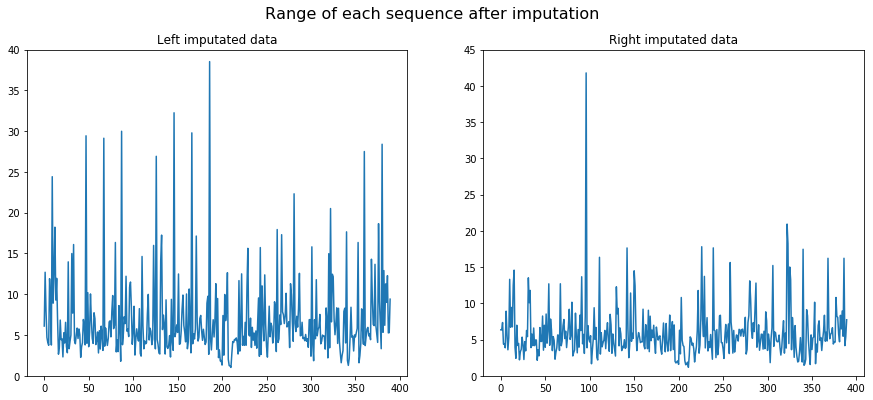

In [34]:
#check there is no zero value in data after imputation
for key in dict_right_key_list:
    column_length=imputation_dict_left[key]
    for i in range(len(column_length)):
        if imputation_dict_left[key][i]==0:
            print(key)
        elif imputation_dict_right[key][i]==0:
            print(key)
print("there is no zero value after imputation")

#check range
range_left_list=[]
range_right_list=[]
for key in dict_right_key_list:
    range_left=max(imputation_dict_left[key])-min(imputation_dict_left[key])
    range_left_list.append(range_left)
    range_right=max(imputation_dict_right[key])-min(imputation_dict_right[key])
    range_right_list.append(range_right)
    
fig=plt.figure(figsize=(15, 6))
ax1=fig.add_subplot(1,2,1)        
ax1.plot(range_left_list)
ax1.set_ylim([0,40])
ax1.set_title("Left imputated data")

ax2=fig.add_subplot(1,2,2)        
ax2.plot(range_right_list)
ax2.set_ylim([0,45])
ax2.set_title("Right imputated data")
fig.suptitle('Range of each sequence after imputation',size=16)
plt.show()

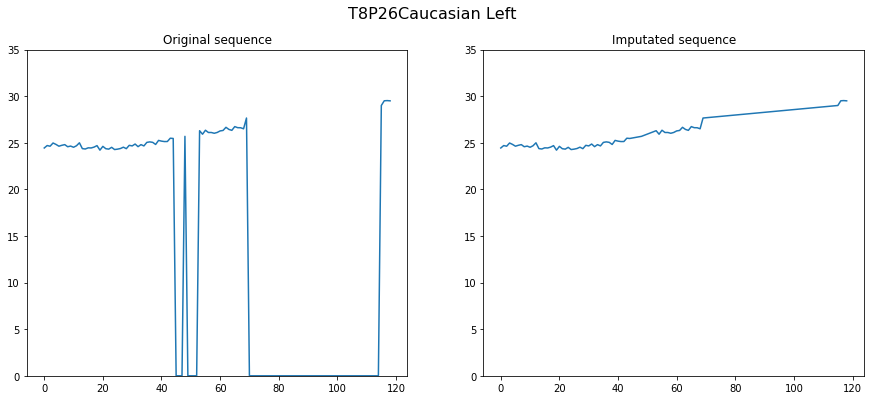

In [35]:
#show an example before and after imputation
fig=plt.figure(figsize=(15, 6))
ax1=fig.add_subplot(1,2,1)        
ax1.plot(dict_left['T8P26Caucasian'])
ax1.set_ylim([0,35])
ax1.set_title("Original sequence")

ax2=fig.add_subplot(1,2,2)        
ax2.plot(imputation_dict_left['T8P26Caucasian'])
ax2.set_ylim([0,35])
ax2.set_title("Imputated sequence")
fig.suptitle('T8P26Caucasian Left',size=16)
plt.show()

In [36]:
#prepare data for hyperparameter selection
data_right=copy.deepcopy(imputation_dict_right)
data_left=copy.deepcopy(imputation_dict_left)
data_mean={}
for k,v in imputation_dict_right.items():
    data_mean[k]=[(g + h) / 2 for g, h in zip(imputation_dict_right[k], imputation_dict_left[k])]

#divide into training,validation and choose hyperparameter, keep label balance as well
validation_index_T=['T3P','T8P']  #random choose two video as validation data
validation_index_F=['F3P','F8P']

validation_index_T_name=[ele for ele in dict_left_key_list if ele[:3]==validation_index_T[0] or ele[:3]==validation_index_T[1]]
validation_index_F_name=[ele for ele in dict_left_key_list if ele[:3]==validation_index_F[0] or ele[:3]==validation_index_F[1]]

train_index_T_name=list(set([ele for ele in dict_left_key_list if ele[0]=="T"])-set(validation_index_T_name))
train_index_F_name=list(set([ele for ele in dict_left_key_list if ele[0]=="F"])-set(validation_index_F_name))

train_index=train_index_T_name+train_index_F_name
validation_index=validation_index_T_name+validation_index_F_name
random.shuffle(train_index)
random.shuffle(validation_index)

print("training data size is ",len(train_index))
print("validation data size is ",len(validation_index))

training data size is  314
validation data size is  76


In [37]:
#convert each sequence to tensor, left eye data
train_x=[]
train_y=[]
for k in train_index:
    if k[0]=='T':
        train_x.append(torch.Tensor(data_left[k]))
        train_y.append(1)
    elif k[0]=='F':
        train_x.append(torch.Tensor(data_left[k]))
        train_y.append(0)

validation_x=[]
validation_y=[]
for k in validation_index:
    if k[0]=='T':
        validation_x.append(torch.Tensor(data_left[k]))
        validation_y.append(1)
    elif k[0]=='F':
        validation_x.append(torch.Tensor(data_left[k]))
        validation_y.append(0)

In [38]:
#post-padding the input data
seq_length_train=[len(seq) for seq in train_x]
seq_length_validation=[len(seq) for seq in validation_x]
max_length=max(seq_length_train+seq_length_validation)

train_x=extend_tensor(train_x)
validation_x=extend_tensor(validation_x)

post_padded_train_x = rnn_utils.pad_sequence(train_x, batch_first=True)
post_padded_validation_x = rnn_utils.pad_sequence(validation_x, batch_first=True)

post_transfer_train_x = Variable(post_padded_train_x.view(post_padded_train_x.size()[0], post_padded_train_x.size()[1], 1))
post_transfer_validation_x = Variable(post_padded_validation_x.view(post_padded_validation_x.size()[0], post_padded_validation_x.size()[1], 1))

train_target = Variable(torch.Tensor(train_y).long())
validation_target = Variable(torch.Tensor(validation_y).long())

In [24]:
#set parameter of LSTM and condidate lr, hidden neurons size
lr_list=[0.0001,0.001,0.003,0.01,0.03,0.1,0.3]
hidden_size_list=[1,5,10,20,40]
num_layers=1
num_classes=2
input_size=1
num_epoch=300
loss_func = nn.CrossEntropyLoss()  

In [16]:
#select best hidden size , give lr is 0.01
lr=0.01
accuracy_on_hidden_size={}
for hidden in hidden_size_list:
    hidden_size=hidden
    lstm_post_model=LSTM_post_padding()
    optimizer_post = torch.optim.Rprop(lstm_post_model.parameters(), lr=lr)
    
    for epoch in range(num_epoch):
        output=lstm_post_model(post_transfer_train_x)
        train_loss = loss_func(output, train_target)                  
        optimizer_post.zero_grad()                           
        train_loss.backward()                             
        optimizer_post.step()
    
    output=lstm_post_model(post_transfer_validation_x)
    validation_loss = loss_func(output, validation_target) 
    final_output=F.softmax(output,dim=1)
    _, predicted = torch.max(final_output, 1)
    total = predicted.size(0)
    correct = predicted.data.numpy() == validation_target.data.numpy()
    validation_accuracy=sum(correct)/total
    print("hidden size is ",hidden, "validation accuracy is ",validation_accuracy)
    accuracy_on_hidden_size[hidden]=validation_accuracy

hidden size is  1 validation accuracy is  0.5
hidden size is  5 validation accuracy is  0.25
hidden size is  10 validation accuracy is  0.5
hidden size is  20 validation accuracy is  0.7631578947368421
hidden size is  40 validation accuracy is  0.6052631578947368


In [17]:
#select best lr
hidden_size=20
accuracy_on_lr={}
for lr in lr_list:
    lstm_post_model=LSTM_post_padding()
    optimizer_post = torch.optim.Rprop(lstm_post_model.parameters(), lr=lr)
    
    for epoch in range(num_epoch):
        output=lstm_post_model(post_transfer_train_x)
        train_loss = loss_func(output, train_target)                  
        optimizer_post.zero_grad()                           
        train_loss.backward()                             
        optimizer_post.step()
    
    output=lstm_post_model(post_transfer_validation_x)
    validation_loss = loss_func(output, validation_target) 
    final_output=F.softmax(output,dim=1)
    _, predicted = torch.max(final_output, 1)
    total = predicted.size(0)
    correct = predicted.data.numpy() == validation_target.data.numpy()
    validation_accuracy=sum(correct)/total
    print("lr is ",lr, "validation accuracy is ",validation_accuracy)
    accuracy_on_lr[lr]=validation_accuracy

lr is  0.0001 validation accuracy is  0.4473684210526316
lr is  0.001 validation accuracy is  0.6842105263157895
lr is  0.003 validation accuracy is  0.5131578947368421
lr is  0.01 validation accuracy is  0.7631578947368421
lr is  0.03 validation accuracy is  0.8026315789473685
lr is  0.1 validation accuracy is  0.7105263157894737
lr is  0.3 validation accuracy is  0.5


In [583]:
#after choose hyperparameters, test model and compare results
#prepare data, training and testing
test_index_T=[['T1P', 'T2P'],['T3P', 'T4P'],['T5P', 'T6P'],['T7P', 'T8P'],['T9P', 'T10']]
test_index_F=[['F1P', 'F2P'],['F3P', 'F4P'],['F5P', 'F6P'],['F7P', 'F8P'],['F9P', 'F10']]
i=0 #change value from 0 to 4 as testing index
print(test_index_T[i])
print(test_index_F[i])

test_index_T_name=[ele for ele in dict_left_key_list if ele[:3]==test_index_T[i][0] or ele[:3]==test_index_T[i][1]]
test_index_F_name=[ele for ele in dict_left_key_list if ele[:3]==test_index_F[i][0] or ele[:3]==test_index_F[i][1]]

train_index_T_name=list(set([ele for ele in dict_left_key_list if ele[0]=="T"])-set(test_index_T_name))
train_index_F_name=list(set([ele for ele in dict_left_key_list if ele[0]=="F"])-set(test_index_F_name))
train_index=train_index_T_name+train_index_F_name
test_index=test_index_T_name+test_index_F_name
random.shuffle(train_index)
random.shuffle(test_index)
print("training data size is ",len(train_index))
print("testing data size is ",len(test_index))


['T1P', 'T2P']
['F1P', 'F2P']
training data size is  320
testing data size is  70


In [584]:
#convert each input sequence to tensor, mean of left and right eye
train_x=[]
train_y=[]
for k in train_index:
    if k[0]=='T':
        train_x.append(torch.Tensor(data_mean[k]))
        train_y.append(1)
    else:
        train_x.append(torch.Tensor(data_mean[k]))
        train_y.append(0)

test_x=[]
test_y=[]
for k in test_index:
    if k[0]=='T':
        test_x.append(torch.Tensor(data_mean[k]))
        test_y.append(1)
    else:
        test_x.append(torch.Tensor(data_mean[k]))
        test_y.append(0)

In [585]:
#conduct pre-padding and post-padding on input data and transfer input tensor into appropriate size
seq_length_train=[len(seq) for seq in train_x]
seq_length_test=[len(seq) for seq in test_x]
max_length=max(seq_length_train+seq_length_test)
#target variable
train_target = Variable(torch.Tensor(train_y).long())
test_target = Variable(torch.Tensor(test_y).long())

#post-padding x
train_x_extend=extend_tensor(train_x)
test_x_extend=extend_tensor(test_x)

post_padded_train_x = rnn_utils.pad_sequence(train_x_extend, batch_first=True)
post_padded_test_x = rnn_utils.pad_sequence(test_x_extend, batch_first=True)

post_transfer_train_x = Variable(post_padded_train_x.view(post_padded_train_x.size()[0], post_padded_train_x.size()[1], 1))
post_transfer_test_x = Variable(post_padded_test_x.view(post_padded_test_x.size()[0], post_padded_test_x.size()[1], 1))

#pre_padding x
reversed_train_x=[reverse_tensor(tensor) for tensor in train_x]
reversed_test_x=[reverse_tensor(tensor) for tensor in test_x]

reversed_train_x_extend=extend_tensor(reversed_train_x)
reversed_test_x_extend=extend_tensor(reversed_test_x)

post_temp_padded_train_x = rnn_utils.pad_sequence(reversed_train_x_extend, batch_first=True)
padded_train_x=[reverse_tensor(tensor) for tensor in post_temp_padded_train_x]
pre_padded_train_x=torch.cat(padded_train_x,0).view(post_temp_padded_train_x.size()[0],post_temp_padded_train_x.size()[1])

post_temp_padded_test_x = rnn_utils.pad_sequence(reversed_test_x_extend, batch_first=True)
padded_test_x=[reverse_tensor(tensor) for tensor in post_temp_padded_test_x]
pre_padded_test_x=torch.cat(padded_test_x,0).view(post_temp_padded_test_x.size()[0],post_temp_padded_test_x.size()[1])

pre_transfer_train_x = Variable(pre_padded_train_x.view(pre_padded_train_x.size()[0], pre_padded_train_x.size()[1], 1))
pre_transfer_test_x = Variable(pre_padded_test_x.view(pre_padded_test_x.size()[0], pre_padded_test_x.size()[1], 1))

In [586]:
#set best hyperparameter
hidden_size=20
lr=0.01 

In [587]:
#post padding lstm
lstm_post_model=LSTM_post_padding()
#optimizer_post = torch.optim.Rprop(lstm_post_model.parameters())
#optimizer_post = torch.optim.Adam(lstm_post_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer_post = torch.optim.RMSprop(lstm_post_model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.1, centered=False)
loss_func = nn.CrossEntropyLoss() 

prediction_list=[]
for epoch in range(100):
    output=lstm_post_model(post_transfer_train_x)
    train_loss = loss_func(output, train_target)                  
    
    if epoch%10==0:
        output=lstm_post_model(pre_transfer_test_x)
        test_loss = loss_func(output, test_target) 
        final_output=F.softmax(output,dim=1)
        _, predicted = torch.max(final_output, 1)
        prediction_list.append(predicted)
        total = predicted.size(0)
        correct = predicted.data.numpy() == test_target.data.numpy()
        test_accuracy=sum(correct)/total
        print('epoch is ',epoch, 'training loss is ',np.round(train_loss.item(),6),'testing loss is ',np.round(test_loss.item(),6),"testing accuracy is ",np.round(test_accuracy,4))
        
    optimizer_post.zero_grad()                           
    train_loss.backward() 
    #torch.nn.utils.clip_grad_norm_(lstm_post_model.parameters(), 1)
    optimizer_post.step()
    

epoch is  0 training loss is  0.685903 testing loss is  0.701689 testing accuracy is  0.5
epoch is  10 training loss is  0.649073 testing loss is  1.804174 testing accuracy is  0.5
epoch is  20 training loss is  0.648789 testing loss is  1.891739 testing accuracy is  0.5
epoch is  30 training loss is  0.64876 testing loss is  1.902777 testing accuracy is  0.5
epoch is  40 training loss is  0.64876 testing loss is  1.904612 testing accuracy is  0.5
epoch is  50 training loss is  0.648766 testing loss is  1.903637 testing accuracy is  0.5
epoch is  60 training loss is  0.648768 testing loss is  1.903359 testing accuracy is  0.5
epoch is  70 training loss is  0.648788 testing loss is  1.898522 testing accuracy is  0.5
epoch is  80 training loss is  0.64885 testing loss is  1.887714 testing accuracy is  0.5
epoch is  90 training loss is  0.649117 testing loss is  1.853389 testing accuracy is  0.5


In [588]:
#pre padding lstm
lstm_pre_model=LSTM_pre_padding()
optimizer_pre = torch.optim.Rprop(lstm_pre_model.parameters(), lr=0.01)
#optimizer_pre=  torch.optim.Adam(lstm_pre_model.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
loss_func = nn.CrossEntropyLoss()   

prediction_list=[]
for epoch in range(100):
    output=lstm_pre_model(pre_transfer_train_x)
    train_loss = loss_func(output, train_target)                  
    
    if epoch%10==0:
        test_output=lstm_pre_model(pre_transfer_test_x)
        test_loss = loss_func(test_output, test_target)
        final_output=F.softmax(test_output,dim=1)
        _, predicted = torch.max(final_output, 1)
        prediction_list.append(predicted)
        total = predicted.size(0)
        correct = predicted.data.numpy() == test_target.data.numpy()
        test_accuracy=sum(correct)/total
        print('epoch is ',epoch, 'training loss is ',np.round(train_loss.item(),6),"testing loss is",np.round(test_loss.item(),6),"test accuracy is ",np.round(test_accuracy,4))
    
    optimizer_pre.zero_grad()                           
    train_loss.backward()                             
    optimizer_pre.step()  
    
        

epoch is  0 training loss is  0.712824 testing loss is 0.713489 test accuracy is  0.5
epoch is  10 training loss is  0.693256 testing loss is 0.692423 test accuracy is  0.4857
epoch is  20 training loss is  0.692936 testing loss is 0.690752 test accuracy is  0.5571
epoch is  30 training loss is  0.692515 testing loss is 0.690853 test accuracy is  0.6143
epoch is  40 training loss is  0.691503 testing loss is 0.687859 test accuracy is  0.6
epoch is  50 training loss is  0.687095 testing loss is 0.662793 test accuracy is  0.6143
epoch is  60 training loss is  0.678273 testing loss is 0.643021 test accuracy is  0.5857
epoch is  70 training loss is  0.671397 testing loss is 0.647071 test accuracy is  0.5429
epoch is  80 training loss is  0.666569 testing loss is 0.637992 test accuracy is  0.5429
epoch is  90 training loss is  0.663255 testing loss is 0.632874 test accuracy is  0.5571


In [589]:
#post padding cnn
cnn_net=CNN_Net()
optimizer_cnn = torch.optim.Rprop(cnn_net.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()  

post_transfer_train_x_cnn = Variable(post_padded_train_x.view(post_padded_train_x.size()[0],1, post_padded_train_x.size()[1]))
post_transfer_test_x_cnn = Variable(post_padded_test_x.view(post_padded_test_x.size()[0],1, post_padded_test_x.size()[1]))

for epoch in range(100):
    output=cnn_net(post_transfer_train_x_cnn)
    train_loss = loss_func(output, train_target)                  
    
    if epoch%10==0:
        output=cnn_net(post_transfer_test_x_cnn)
        test_loss = loss_func(output, test_target)
        final_output=F.softmax(output,dim=1)
        _, predicted = torch.max(final_output, 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == test_target.data.numpy()
        test_accuracy=sum(correct)/total
        print('epoch is ',epoch, 'training loss is ',np.round(train_loss.item(),6)," testing loss is",np.round(test_loss.item(),6)," testing accuracy is ",np.round(test_accuracy,4))
    
    optimizer_cnn.zero_grad()                           
    train_loss.backward() 
    optimizer_cnn.step()

epoch is  0 training loss is  1.239139  testing loss is 0.895068  testing accuracy is  0.5857
epoch is  10 training loss is  0.221604  testing loss is 0.985432  testing accuracy is  0.5
epoch is  20 training loss is  0.091644  testing loss is 0.027564  testing accuracy is  1.0
epoch is  30 training loss is  0.07844  testing loss is 0.000462  testing accuracy is  1.0
epoch is  40 training loss is  0.068345  testing loss is 0.05724  testing accuracy is  0.9857
epoch is  50 training loss is  0.0613  testing loss is 3.033812  testing accuracy is  0.8714
epoch is  60 training loss is  0.617508  testing loss is 0.016933  testing accuracy is  0.9857
epoch is  70 training loss is  0.12052  testing loss is 0.248001  testing accuracy is  0.9714
epoch is  80 training loss is  0.069504  testing loss is 1.600047  testing accuracy is  0.9857
epoch is  90 training loss is  0.020123  testing loss is 12.66345  testing accuracy is  0.9286


In [590]:
#pre padding cnn
cnn_net=CNN_Net()
optimizer_cnn = torch.optim.Rprop(cnn_net.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()  

pre_transfer_train_x_cnn = Variable(pre_padded_train_x.view(pre_padded_train_x.size()[0],1, pre_padded_train_x.size()[1]))
pre_transfer_test_x_cnn = Variable(pre_padded_test_x.view(pre_padded_test_x.size()[0],1, pre_padded_test_x.size()[1]))

for epoch in range(100):
    output=cnn_net(pre_transfer_train_x_cnn)
    train_loss = loss_func(output, train_target)                  
    
    if epoch%10==0:
        output=cnn_net(pre_transfer_test_x_cnn)
        test_loss = loss_func(output, test_target)
        final_output=F.softmax(output,dim=1)
        _, predicted = torch.max(final_output, 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == test_target.data.numpy()
        test_accuracy=sum(correct)/total
        print('epoch is ',epoch, 'training loss is ',np.round(train_loss.item(),6)," testing loss is",np.round(test_loss.item(),6)," testing accuracy is ",np.round(test_accuracy,4))
    
    optimizer_cnn.zero_grad()                           
    train_loss.backward()                             
    optimizer_cnn.step()

epoch is  0 training loss is  1.577528  testing loss is 1.308963  testing accuracy is  0.5
epoch is  10 training loss is  0.298023  testing loss is 0.755267  testing accuracy is  0.4714
epoch is  20 training loss is  0.083205  testing loss is 0.092572  testing accuracy is  1.0
epoch is  30 training loss is  0.064329  testing loss is 0.002819  testing accuracy is  1.0
epoch is  40 training loss is  0.049148  testing loss is 0.003061  testing accuracy is  1.0
epoch is  50 training loss is  0.036969  testing loss is 1.387707  testing accuracy is  0.9571
epoch is  60 training loss is  0.025529  testing loss is 2.866437  testing accuracy is  0.8714
epoch is  70 training loss is  0.01794  testing loss is 2.426594  testing accuracy is  0.7857
epoch is  80 training loss is  0.005882  testing loss is 0.957761  testing accuracy is  0.9571
epoch is  90 training loss is  0.001033  testing loss is 3.096749  testing accuracy is  0.8714
